In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[-8:]

['zyell', 'zyheem', 'zykeem', 'zylas', 'zyran', 'zyrie', 'zyron', 'zzyzx']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


This dataset is structured such that, given a sequence of characters (context), the goal is to predict the next character in the sequence.

In [101]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch] # obtain each indx of the char
      X.append(context) # current context of chars
      Y.append(ix) # indx of current char
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

      # The context list is updated by cropping the first element and appending the index 
      # of the current character. This keeps track of the context for the next 
      # iteration.

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # training set
Xdev, Ydev = build_dataset(words[n1:n2]) # dev set
Xte, Yte = build_dataset(words[n2:]) # test set

torch.Size([182691, 3]) torch.Size([182691])
torch.Size([22793, 3]) torch.Size([22793])
torch.Size([22662, 3]) torch.Size([22662])


In [149]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 12), generator=g)
W1 = torch.randn((36, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [150]:
sum(p.nelement() for p in parameters) # number of parameters in total

19551

In [151]:
for p in parameters:
  p.requires_grad = True

In [156]:
lre = torch.linspace(-2, 0, 1000)
lrs = 10**lre

In [157]:
lri = []
lossi = []
stepi = []

In [158]:
for i in range(300000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (64,))
  
  # forward pass
  emb = C[Xtr[ix]] # Embedding lookup
  h = torch.tanh(emb.view(-1, 36) @ W1 + b1) # hidden layer with tanh
  logits = h @ W2 + b2 # # Output layer
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

1.800782322883606


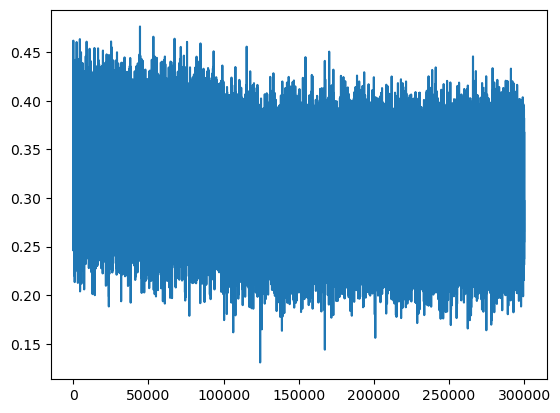

In [159]:
plt.plot(stepi, lossi)

In [160]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 36) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0274, grad_fn=<NllLossBackward0>)

In [161]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 36) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1170, grad_fn=<NllLossBackward0>)

In [162]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 36) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1377, grad_fn=<NllLossBackward0>)

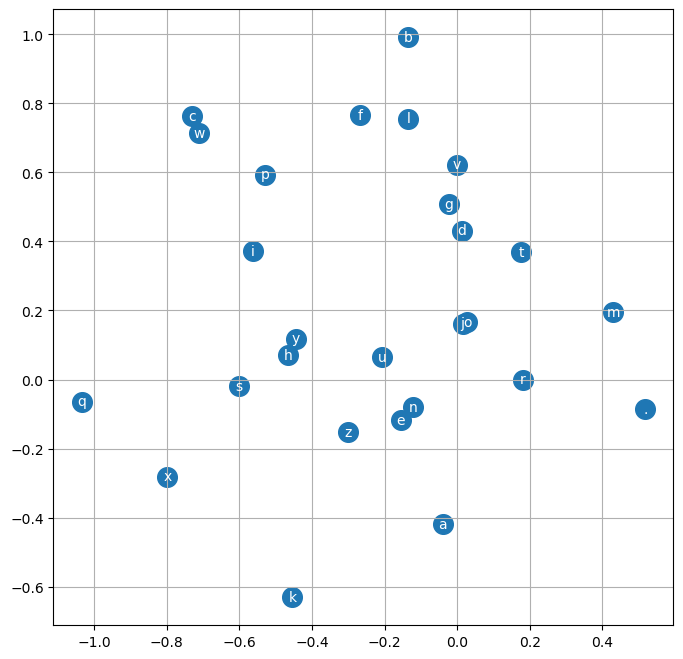

In [163]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [164]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mona.
mayah.
see.
mad.
ryla.
rensleigh.
raegendered.
elin.
shi.
jenleigh.
vananaraelyzion.
kalin.
shub.
ridhiriel.
janie.
jenionnie.
cayu.
zayven.
jamelizeha.
kayshayvella.
